In [1]:
# Playgroud Series - Binary Prediction of Poisonous Mushrooms
  # ttps://www.kaggle.com/competitions/playground-series-s4e8/
  # Your Goal: predict whether a mushroom is edible or poisonous based on its physical characteristics.
  # Metric: Submissions are evaluated using the Matthews correlation coefficient (MCC): iT is used in machine learning as a measure of the quality of binary and multiclass classifications.

In [ ]:
# Possible improvements:
    # Run CatBoost with more estimators will give better results.
    # Feature selection
    # As long as there is a lot of NaNs, many people fill them with the mode, or sth similar.
        # Score improves when, rather than imputing these NaNs with mode value, one assigns them with a dedicated category instead. 
        # https://www.kaggle.com/competitions/playground-series-s4e8/discussion/524014

# Imports

In [471]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
#import polars as pl

from sklearn.impute import KNNImputer

from sklearn.model_selection         import train_test_split, GridSearchCV#, StratifiedKFold#, cross_val_score
# from sklearn.preprocessing         import MinMaxScaler #OneHotEncoder  
# from sklearn.metrics               import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
# from sklearn.tree                  import DecisionTreeClassifier, plot_tree
#from sklearn.ensemble               import RandomForestClassifier
# from sklearn.linear_model          import LogisticRegressionCV, LogisticRegression


from catboost                        import CatBoostClassifier, Pool #Numpy downgrade needed: pip install numpy==1.26.4 (from mar/24), and Open new jupyter from that terminal to get the new version!
# from sklearn.pipeline              import Pipeline
# from skopt                         import BayesSearchCV, space

pd.set_option('max_colwidth', 100) #cols to be shown
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x) #pandas decimal places
#np.set_printoptions(suppress=True, precision=3)#numpy decimal places

# Load Data

In [69]:
train = pd.read_csv('..\\dt\\kaggle\\train.csv', index_col='id')
print(train.shape)
train.rename(columns={'class':'target'}, inplace=True) #class is reserved python word
train[:2]

(3116945, 21)


,target,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.800,f,s,u,f,a,c,w,4.510,15.390,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.510,x,h,o,f,a,c,n,4.790,6.480,NaN,y,o,NaN,NaN,t,z,NaN,d,w


In [70]:
train['target'].value_counts()

target
p    1705396
e    1411549
Name: count, dtype: int64

In [71]:
train = train.copy()
# Balanced Classification problem

# Data Cleaning

In [72]:
# Meanings:

In [73]:

# target: poisonous(p), eatable(e) 
# cap-diameter (m): float number in cm
# cap-shape (n): bell=b, conical=c, convex=x, flat=f, sunken=s, spherical=p, others=o
# cap-surface (n): fibrous=i, grooves=g, scaly=y, smooth=s, shiny=h, leathery=l, silky=k, sticky=t, wrinkled=w, fleshy=e
# cap-color (n): brown=n, buff=b, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y, blue=l, orange=o, black=k
# does-bruise-or-bleed (n): bruises-or-bleeding=t, no=f
# gill-attachment (n): adnate=a, adnexed=x, decurrent=d, free=e, sinuate=s, pores=p, none=f, unknown=?
# gill-spacing (n): close=c, distant=d, none=f
# gill-color (n): see cap-color + none=f
# stem-height (m): float number in cm
# stem-width (m): float number in mm
# stem-root (n): bulbous=b, swollen=s, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r
# stem-surface (n): see cap-surface + none=f
# stem-color (n): see cap-color + none=f
# veil-type (n): partial=p, universal=u
# veil-color (n): see cap-color + none=f
# has-ring (n): ring=t, none=f
# ring-type (n): cobwebby=c, evanescent=e, flaring=r, grooved=g, large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?
# spore-print-color (n): see cap color
# habitat (n): grasses=g, leaves=l, meadows=m, paths=p, heaths=h, urban=u, waste=w, woods=d
# season (n): spring=s, summer=u, autumn=a, winter=w 

In [74]:
# Col names  -> PASS!
#convert all cols to lower case, and replace spaces and dots with underscores
#df.columns = df.columns.str.replace('-','_').str.lower()

In [75]:
# Feature Variation Cleaning (there is noise!)

In [76]:
# Step 1: Separate numerical and categorical columns
num_cols = train.select_dtypes(include=['float64', 'int64']).columns
cat_cols = train.select_dtypes(include=['object']).columns

In [77]:
# Variations of each column
print(f"- Distinct values:\n{train[cat_cols].apply( lambda x: x.unique().shape[0] ) } \n" )
print(f"- Variations:\n{train[cat_cols].apply( lambda x: x.unique() ) } " )

- Distinct values:
target                   2
cap-shape               75
cap-surface             84
cap-color               79
does-bruise-or-bleed    27
gill-attachment         79
gill-spacing            49
gill-color              64
stem-root               39
stem-surface            61
stem-color              60
veil-type               23
veil-color              25
has-ring                24
ring-type               41
spore-print-color       33
habitat                 53
season                   4
dtype: int64 

- Variations:
target                                                                                                               [e, p]
cap-shape               [f, x, p, b, o, c, s, d, e, n, nan, w, k, l, 19.29, 5 f, t, g, z, a, 2.85, 7 x, r, u, 3.55, is s...
cap-surface             [s, h, y, l, t, e, g, nan, d, i, w, k, 15.94, f, n, r, o, a, u, z, 2.7, does l, 5.07, p, b, m, c...
cap-color               [u, o, b, g, w, n, e, y, r, p, k, l, i, h, d, s, a, f, 2.05, season, c

In [78]:
# Inspecting cat vars, lok like noise has less than 10 samples per variable. 
train['spore-print-color'].value_counts()

spore-print-color
k             107310
p              68237
w              50173
n              22646
r               7975
u               7256
g               3492
y                 36
s                 21
c                 16
e                 14
f                 14
t                 13
a                 13
d                  9
l                  8
b                  5
m                  4
h                  3
o                  3
x                  2
i                  2
veil-color         2
10 None            1
9 None             1
2.49               1
class              1
2.62               1
season             1
9.55               1
6.36               1
4.58               1
Name: count, dtype: int64

In [79]:
# Remove variations with few samples (considering noise)

In [80]:
def remove_low_variation_rows(df, columns, thr=10):
    """
    Remove rows from the DataFrame where the variation of the specified features has 10 (n) or fewer samples.
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    columns (list): List of categorical columns to check for variation.
    threshold (int): The minimum number of samples required for a category to be retained.  
    Returns:
    pd.DataFrame: A DataFrame with low variation rows removed.
    """
    for col in columns:
        # Count the occurrences of each category
        value_counts = df[col].value_counts()
        
        # Identify categories with counts less than or equal to the threshold
        low_variation_categories = value_counts[value_counts <= thr].index
        
        # Remove rows where the feature value is in the low variation categories
        df = df[~df[col].isin(low_variation_categories)]
        df.reset_index(drop=True, inplace=True)
    
    return df

In [83]:
# Call the function
train = remove_low_variation_rows(train, cat_cols, thr=30)

In [84]:
train.shape

(3114426, 21)

In [85]:
train._is_copy

In [87]:
train[:2]

,target,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.800,f,s,u,f,a,c,w,4.510,15.390,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.510,x,h,o,f,a,c,n,4.790,6.480,NaN,y,o,NaN,NaN,t,z,NaN,d,w


In [88]:
#variations of each column
print(f"- Distinct values:\n{train[cat_cols].apply( lambda x: x.unique().shape[0] ) } \n" )
print(f"- Variations:\n{train[cat_cols].apply( lambda x: x.unique() ) } " )

- Distinct values:
target                   2
cap-shape               16
cap-surface             22
cap-color               16
does-bruise-or-bleed     3
gill-attachment         13
gill-spacing             4
gill-color              19
stem-root                6
stem-surface            13
stem-color              17
veil-type                2
veil-color               7
has-ring                 3
ring-type               13
spore-print-color        9
habitat                 17
season                   4
dtype: int64 

- Variations:
target                                                                                [e, p]
cap-shape                                 [f, x, p, b, o, c, s, d, e, n, nan, w, t, g, r, y]
cap-surface             [s, h, y, l, t, e, g, nan, d, i, w, k, f, n, r, o, a, u, p, m, x, c]
cap-color                                 [u, o, b, g, w, n, e, y, r, p, k, l, d, s, f, nan]
does-bruise-or-bleed                                                             [f, t, nan]
g

In [89]:
#Looks ok now! 
#There is a chance of some variation be on test, that is not on train, but since we have 3MI + data, it may not have impact. 

In [90]:
#train_bk = train.copy()
#train = train_bk.copy()

In [91]:
# NAs

In [92]:
## Missings
train.isna().sum().sort_values()

target                        0
stem-height                   0
stem-width                    0
season                        0
cap-diameter                  4
does-bruise-or-bleed          8
cap-color                    12
has-ring                     24
stem-color                   37
cap-shape                    40
habitat                      45
gill-color                   56
ring-type                128783
gill-attachment          523619
cap-surface              670573
gill-spacing            1257452
stem-surface            1979497
veil-color              2738962
stem-root               2755034
spore-print-color       2847554
veil-type               2955240
dtype: int64

In [93]:
#df.dropna() #drops hole dataset!

In [94]:
train.shape

(3114426, 21)

In [95]:
# Step 1: Impute missing values in numerical columns using KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_numerical_imputed = pd.DataFrame(imputer.fit_transform(train[num_cols]), columns=num_cols)

In [102]:
# Step 2: Handle missing values in categorical columns
# Option 1: Fill with some statistic: used MODE
for col in cat_cols:
    mode_value = train[col].mode()[0]  # Get the mode
    train.loc[:, col] = train[col].fillna(mode_value)  # Assign the filled values back to the DataFrame

In [103]:
# Step 3: Combine the imputed numerical DataFrame with the categorical DataFrame
train = pd.concat([df_numerical_imputed, train[cat_cols]], axis=1).copy()

In [110]:
train[:2]

,cap-diameter,stem-height,stem-width,target,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.800,4.510,15.390,e,f,s,u,f,a,c,w,b,s,w,u,w,f,f,k,d,a
1,4.510,4.790,6.480,p,x,h,o,f,a,c,n,b,y,o,u,w,t,z,k,d,w


In [111]:
#Reorder cols with target in the end: 
# Identify the target and Reorder columns to move the target variable to the last position
cols = [col for col in train.columns if col != 'target']  # All columns except the target
cols.append('target')  # Add the target variable to the end
train = train[cols].copy()

In [112]:
train._is_copy

In [113]:
train[:2]

,cap-diameter,stem-height,stem-width,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,target
0,8.800,4.510,15.390,f,s,u,f,a,c,w,b,s,w,u,w,f,f,k,d,a,e
1,4.510,4.790,6.480,x,h,o,f,a,c,n,b,y,o,u,w,t,z,k,d,w,p


In [114]:
# Check
train.isna().sum().sort_values()

cap-diameter            0
habitat                 0
spore-print-color       0
ring-type               0
has-ring                0
veil-color              0
veil-type               0
stem-color              0
stem-surface            0
season                  0
stem-root               0
gill-spacing            0
gill-attachment         0
does-bruise-or-bleed    0
cap-color               0
cap-surface             0
cap-shape               0
stem-width              0
stem-height             0
gill-color              0
target                  0
dtype: int64

In [115]:
#done!

In [116]:
#Dtypes
train.dtypes

cap-diameter            float64
stem-height             float64
stem-width              float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
target                   object
dtype: object

In [117]:
# string -> keep object 
# numeric -> are already float

# parse target to numeric:
train.target.value_counts()

target
p    1703904
e    1410522
Name: count, dtype: int64

In [118]:
#poisonous = 1, eatable = 0
train.target = train.target.apply(lambda x: 1 if x == 'p' else 0)

In [119]:
train.target.value_counts()

target
1    1703904
0    1410522
Name: count, dtype: int64

In [120]:
train.target = train.target.astype(int)

In [121]:
train.dtypes

cap-diameter            float64
stem-height             float64
stem-width              float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
target                    int32
dtype: object

In [122]:
#Ok!

# Checkpoint 1

In [123]:
train.to_parquet('..\\dt\\v1\\train_clean.parquet', )

In [124]:
train = pd.read_parquet( '..\\dt\\v1\\train_clean.parquet')
print(train.shape)
train[:2]

(3114426, 21)


,cap-diameter,stem-height,stem-width,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,target
0,8.800,4.510,15.390,f,s,u,f,a,c,w,b,s,w,u,w,f,f,k,d,a,0
1,4.510,4.790,6.480,x,h,o,f,a,c,n,b,y,o,u,w,t,z,k,d,w,1


# EDA

In [125]:
# Distribution of num cols

In [126]:
num_cols

Index(['cap-diameter', 'stem-height', 'stem-width'], dtype='object')

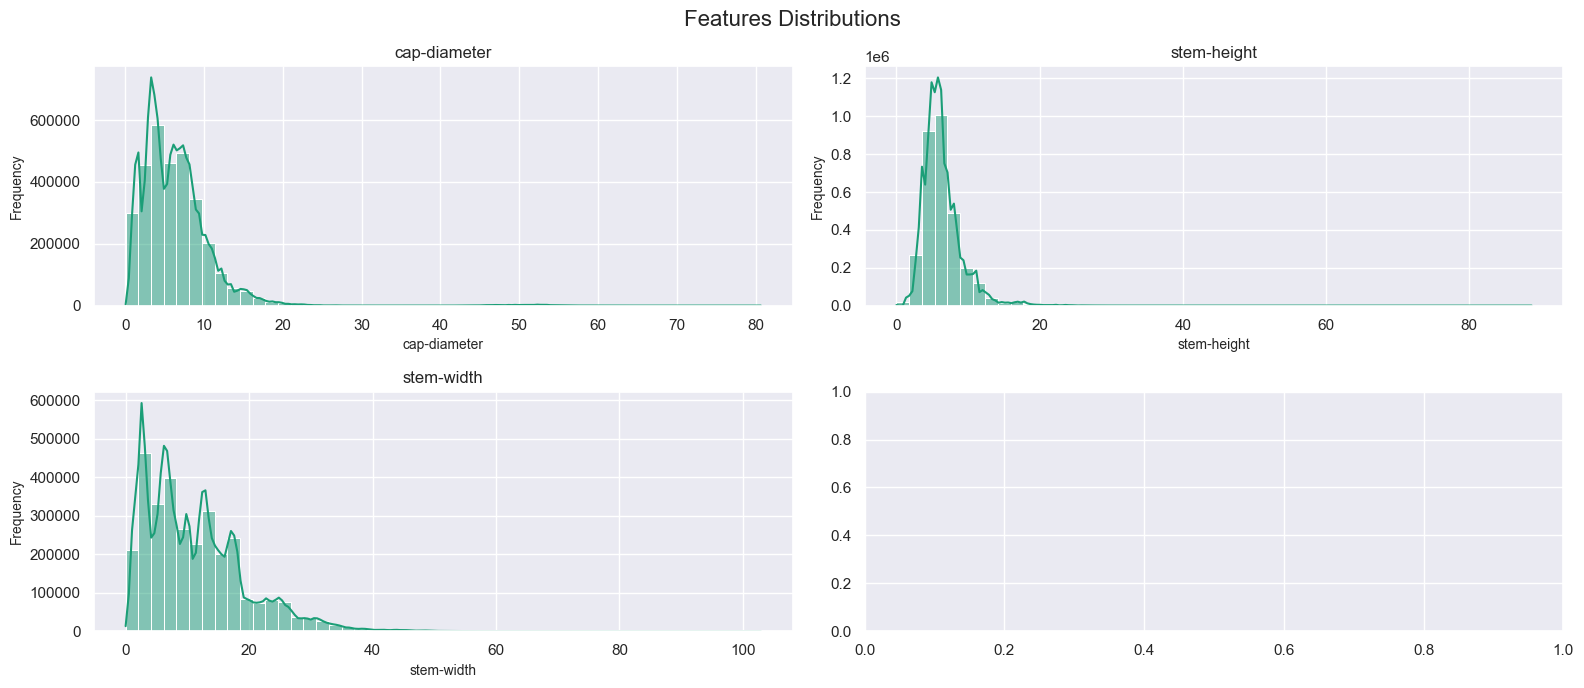

In [127]:
# Set the style for seaborn
sns.set(style="darkgrid")

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 7)) 
fig.suptitle("Features Distributions", fontsize=16)

# Loop through the columns and create histograms
for ax, col in zip(axs.flatten(), train[num_cols]):
    sns.histplot(train[col], ax=ax, bins=50, kde=True, color=sns.color_palette("Dark2")[0])  # Add KDE for smoothness
    ax.set_title(col, fontsize=12)
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.grid(True)  # Add grid lines for better readability

# Adjust layout
fig.tight_layout()  
fig.subplots_adjust(top=0.9)  
plt.show()

In [128]:
# meanings:

# cap-diameter (m): float number in cm
# stem-height (m): float number in cm
# stem-width (m): float number in mm

In [129]:
# Distribution of cat cols

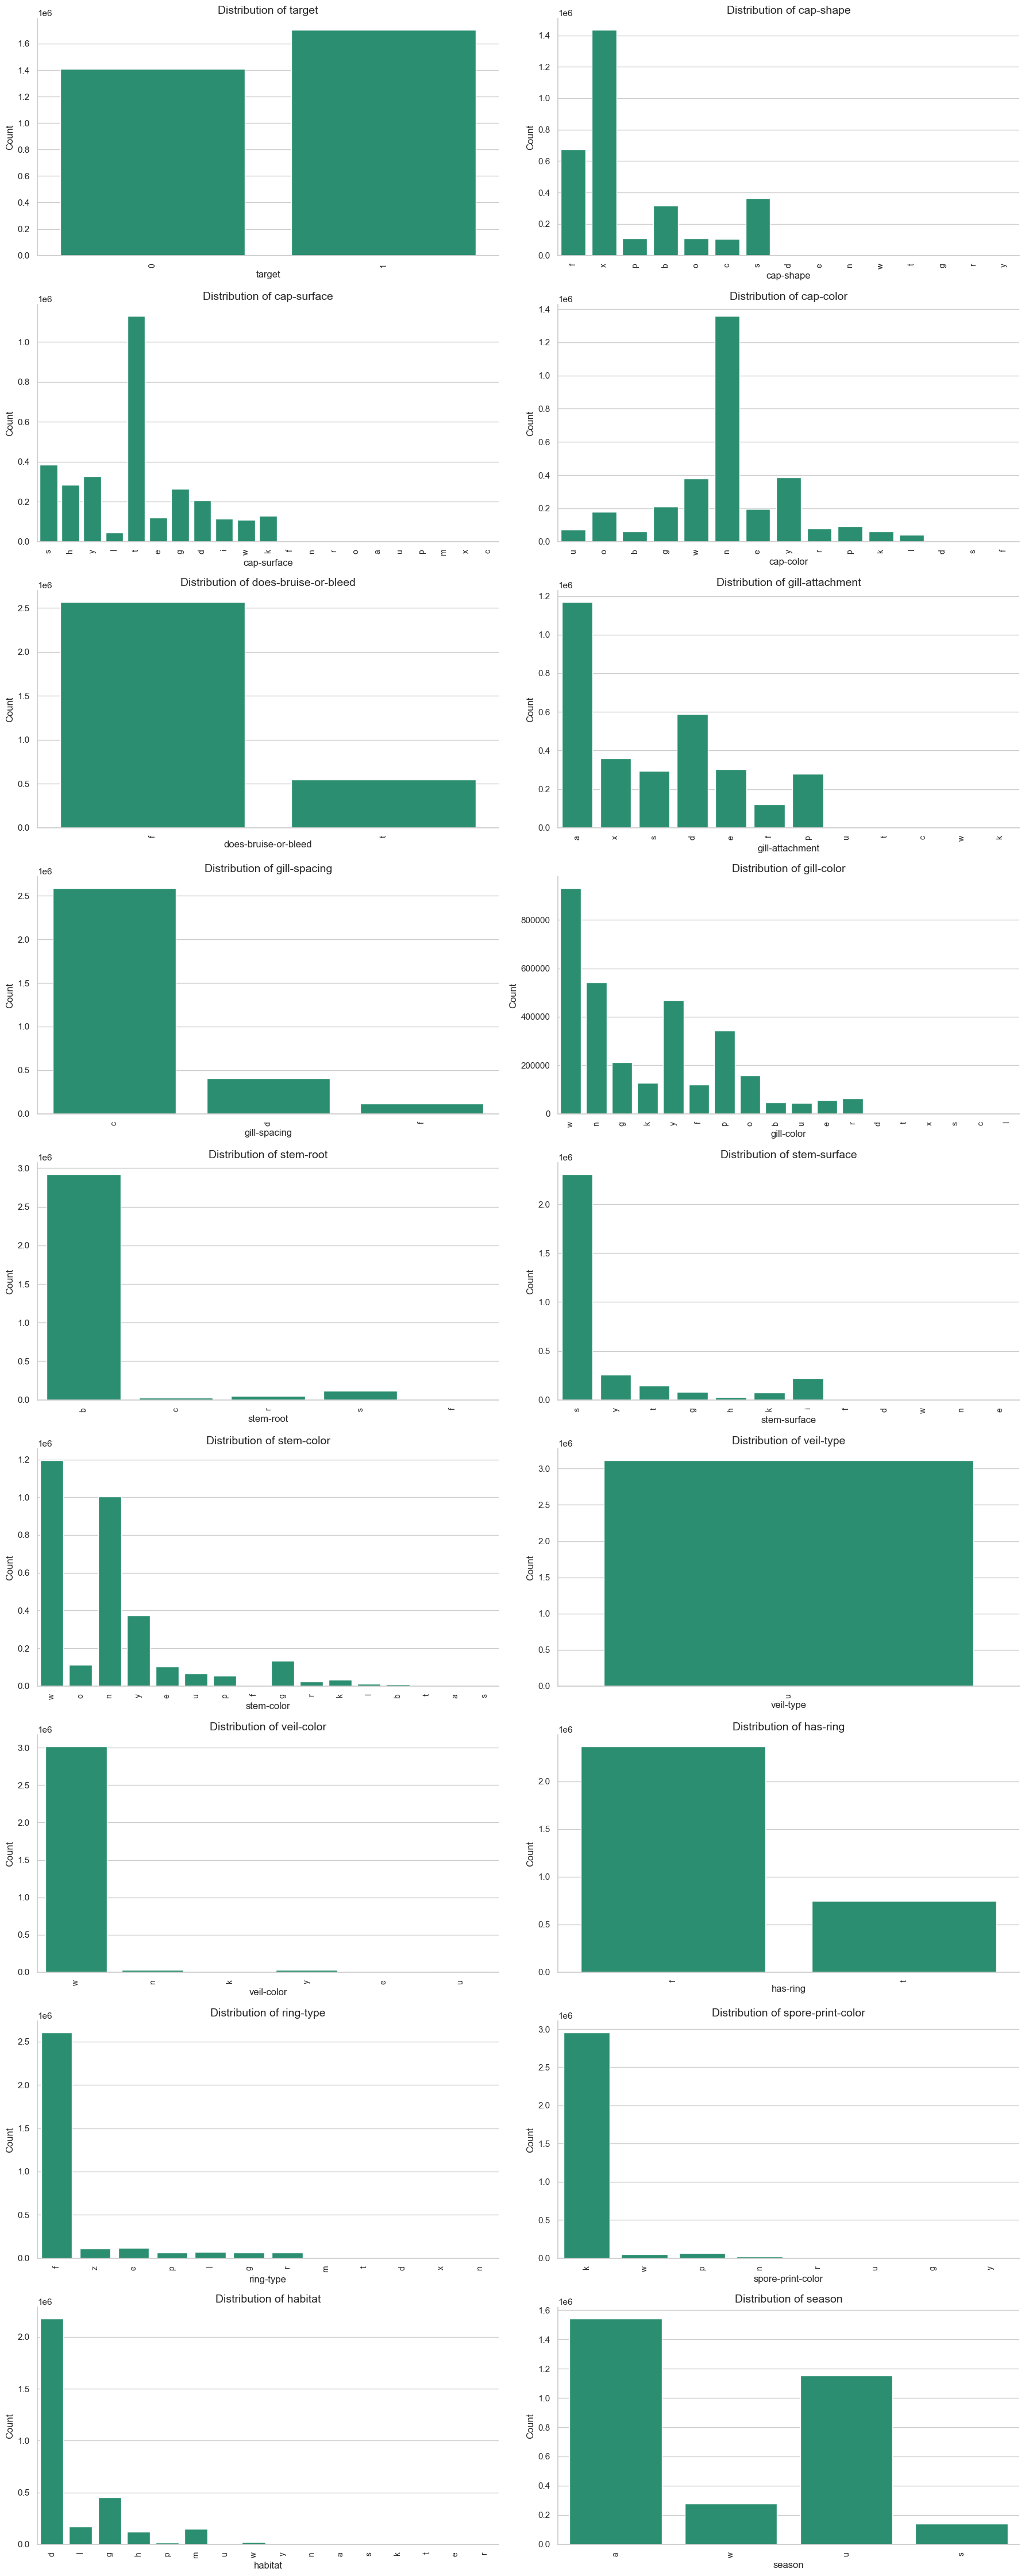

In [130]:
# Set the style for seaborn
sns.set(style="darkgrid")  # You can choose other styles like "darkgrid", "ticks", etc.

num_cols = 2
num_rows = (len(cat_cols) + num_cols - 1) // num_cols  # Calculate number of rows needed

plt.figure(figsize=(18, num_rows * 5))  # Adjust height based on number of rows

# Loop through each categorical column and create a bar plot
for i, col in enumerate(cat_cols):
    plt.subplot(num_rows, num_cols, i + 1)  # Create a subplot for each column
    sns.countplot(data=train, x=col, color=sns.color_palette("Dark2")[0])  # Create a count plot with specified color
    plt.title(f'Distribution of {col}', fontsize=14)  # Set the title with larger font size
    plt.xlabel(col, fontsize=12)  # Set x-axis label
    plt.ylabel('Count', fontsize=12)  # Set y-axis label
    plt.xticks(rotation=90, fontsize=10)  # Rotate x labels for better readability
    sns.despine()  # Remove the top and right spines for a cleaner look

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots

In [ ]:
#meanings:

# target: poisonous(p), eatable(e) 
# cap-shape (n): bell=b, conical=c, convex=x, flat=f, sunken=s, spherical=p, others=o
# cap-surface (n): fibrous=i, grooves=g, scaly=y, smooth=s, shiny=h, leathery=l, silky=k, sticky=t, wrinkled=w, fleshy=e
# cap-color (n): brown=n, buff=b, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y, blue=l, orange=o, black=k
# does-bruise-or-bleed (n): bruises-or-bleeding=t, no=f
# gill-attachment (n): adnate=a, adnexed=x, decurrent=d, free=e, sinuate=s, pores=p, none=f, unknown=?
# gill-spacing (n): close=c, distant=d, none=f
# gill-color (n): see cap-color + none=f
# stem-root (n): bulbous=b, swollen=s, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r
# stem-surface (n): see cap-surface + none=f
# stem-color (n): see cap-color + none=f
# veil-type (n): partial=p, universal=u
# veil-color (n): see cap-color + none=f
# has-ring (n): ring=t, none=f
# ring-type (n): cobwebby=c, evanescent=e, flaring=r, grooved=g, large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?
# spore-print-color (n): see cap color
# habitat (n): grasses=g, leaves=l, meadows=m, paths=p, heaths=h, urban=u, waste=w, woods=d
# season (n): spring=s, summer=u, autumn=a, winter=w 

In [131]:
#Better now, but still we see lots of classes with few data. Keep going right now!

# Dataset Split

In [132]:
X = train.drop(columns="target") 
y = train.target

In [133]:
#split between train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 98, stratify = y, test_size = 0.20) #stratify by y

In [134]:
# train data
print('X_train -> ',X_train.shape)
print('y_train -> ',y_train.shape)
# test data
print('X_test -> ',X_test.shape)
print('y_test -> ',y_test.shape)

X_train ->  (2491540, 20)
y_train ->  (2491540,)
X_test ->  (622886, 20)
y_test ->  (622886,)


# ML

In [135]:
## Random Forest

In [137]:
X_train[:1]

,cap-diameter,stem-height,stem-width,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
1128539,4.060,5.910,7.230,x,h,y,f,a,c,y,b,g,o,u,w,f,f,k,g,a


In [144]:
y_train[:1]

1128539    1
Name: target, dtype: int32

In [345]:
X_train_10 = X_train.copy()

In [346]:
y_train_10 = y_train.copy()

In [347]:
X_train_10[:2]

,cap-diameter,stem-height,stem-width,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
1128539,4.060,5.910,7.230,x,h,y,f,a,c,y,b,g,o,u,w,f,f,k,g,a
332916,12.230,8.460,18.290,x,s,n,f,s,c,p,b,i,n,u,w,f,f,k,d,a


In [348]:
X_train_10.columns

Index(['cap-diameter', 'stem-height', 'stem-width', 'cap-shape', 'cap-surface',
       'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing',
       'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type',
       'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat',
       'season'],
      dtype='object')

In [349]:
#X_train_10[['cap-diameter','stem-height','stem-width']][:2]

In [350]:
#X_train_10.drop(columns = 'cap-shape', inplace=True)

In [351]:
# Convert to category if necessary
# if X_train_10[problematic_feature].dtype != 'category':
#     X_train_10[problematic_feature] = X_train_10[problematic_feature].astype('category')

In [352]:
#X_train_10.dtypes

In [395]:
# GridSearch + Cross Validation

# dictionary of possible hiperparameters to test their combinations
param_grid_cb = {'max_depth': [7]}# ,15], 'learning_rate': [0.01, 0.05]}#  'class_weight': [None, 'balanced', {0: 1, 1: 2.5}  , 'max_leaf_nodes': [10, 40, 100]  , 'min_samples_leaf':[5, 20, 45], }
    #'class_weight': {0: 1, 1: 2.5} balancing manually, to give more importance to the minority class.
# -> max_leaf_nodes and min_samples_leaf did not improve the model's performance
print("Parameter grid RF:\n{}".format(param_grid_cb))

Parameter grid RF:
{'max_depth': [7]}


In [396]:
# instantiate a DT Classifier, on a GridSearchCV, and the number of K folds:
CatBoost = GridSearchCV(CatBoostClassifier(n_estimators=20, random_state=98, cat_features=['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type','veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']), param_grid_cb, cv=2, n_jobs=1, scoring='matthews_corrcoef', return_train_score=True)
CatBoost.fit(X_train_10, y_train_10)   # [['cap-diameter','stem-height','stem-width', 'cap-shape']]

Learning rate set to 0.5
0:	learn: 0.5652685	total: 684ms	remaining: 13s
1:	learn: 0.4772464	total: 1.16s	remaining: 10.5s
2:	learn: 0.3936601	total: 1.74s	remaining: 9.87s
3:	learn: 0.3311041	total: 2.22s	remaining: 8.89s
4:	learn: 0.2792309	total: 2.7s	remaining: 8.09s
5:	learn: 0.2439766	total: 3.18s	remaining: 7.42s
6:	learn: 0.2145057	total: 3.77s	remaining: 7s
7:	learn: 0.1932589	total: 4.26s	remaining: 6.38s
8:	learn: 0.1653907	total: 4.74s	remaining: 5.79s
9:	learn: 0.1533472	total: 5.17s	remaining: 5.17s
10:	learn: 0.1347540	total: 5.63s	remaining: 4.6s
11:	learn: 0.1235684	total: 6.07s	remaining: 4.04s
12:	learn: 0.1143342	total: 6.52s	remaining: 3.51s
13:	learn: 0.1092073	total: 6.96s	remaining: 2.98s
14:	learn: 0.0985482	total: 7.44s	remaining: 2.48s
15:	learn: 0.0928270	total: 7.89s	remaining: 1.97s
16:	learn: 0.0876062	total: 8.34s	remaining: 1.47s
17:	learn: 0.0830669	total: 8.79s	remaining: 977ms
18:	learn: 0.0785573	total: 9.24s	remaining: 486ms
19:	learn: 0.0767818	to

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000153043978F0>,
             n_jobs=1, param_grid={'max_depth': [7]}, return_train_score=True,
             scoring='matthews_corrcoef')

In [ ]:
#PicklingError: Could not pickle the task to send it to the workers.

In [397]:
# Get best parameters, and also the best score with cross-validation (VAL DATA):
print("RF Best parameters (val): {}".format(CatBoost.best_params_))
print("RF Best cross-validation score (val): {:.3f}".format(CatBoost.best_score_))

RF Best parameters (val): {'max_depth': 7}
RF Best cross-validation score (val): 0.964


In [398]:
# Best model trained in VAL:
#rf_best_estimator = CatBoost.best_estimator_
#print("RF Best estimator (val): {}".format(rf_best_estimator))

In [400]:
# Ranking of best models with CV, considering all given combinations of parameters. (mean_test_score = VAL):
pd.DataFrame(CatBoost.cv_results_)[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:5]

,rank_test_score,params,mean_train_score,mean_test_score
0,1,{'max_depth': 7},0.964,0.964


In [474]:
# Access the best estimator
best_model = grid_src_RFClassif.best_estimator_

In [475]:
#Get feature importances:
# Create a Pool object with your training data and specify categorical features
train_pool = Pool(X_train, cat_features=['cap-shape', 'cap-surface', 'cap-color', 
                                         'does-bruise-or-bleed', 'gill-attachment', 
                                         'gill-spacing', 'gill-color', 'stem-root', 
                                         'stem-surface', 'stem-color', 'veil-type', 
                                         'veil-color', 'has-ring', 'ring-type', 
                                         'spore-print-color', 'habitat', 'season'])

# Get feature importances
feature_importances = best_model.get_feature_importance(data=train_pool)

In [478]:
#Feature importances:
sorted_importances = sorted(zip(X_train.columns, feature_importances), key=lambda x: x[1], reverse=True)
top_features = [feature for feature, importance in sorted_importances]
print("Top features ordered by importance:", top_features)

Top features ordered by importance: ['stem-width', 'stem-color', 'gill-attachment', 'stem-surface', 'gill-spacing', 'cap-surface', 'does-bruise-or-bleed', 'stem-height', 'has-ring', 'gill-color', 'cap-diameter', 'cap-color', 'cap-shape', 'stem-root', 'ring-type', 'veil-color', 'season', 'veil-type', 'spore-print-color', 'habitat']


# Kaggle Test Prediction

In [419]:
# Load .csv w/ Pandas (production data, to submit predictions)
X_prod = pd.read_csv('..\\dt\\kaggle\\test.csv')
X_prod

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.640,x,NaN,n,t,NaN,NaN,w,11.130,17.120,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.900,o,t,o,f,NaN,c,y,1.270,10.750,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,3116947,2.000,b,g,n,f,NaN,c,n,6.180,3.140,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3,3116948,3.470,x,t,n,f,s,c,n,4.980,8.510,NaN,NaN,w,NaN,n,t,z,NaN,d,u
4,3116949,6.170,x,h,y,f,p,NaN,y,6.730,13.700,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077959,5194904,0.880,x,g,w,f,a,d,w,2.670,1.350,NaN,NaN,e,NaN,NaN,f,f,NaN,d,u
2077960,5194905,3.120,x,s,w,f,d,c,w,2.690,7.380,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
2077961,5194906,5.730,x,e,e,f,a,NaN,w,6.160,9.740,NaN,NaN,y,NaN,w,t,z,NaN,d,a
2077962,5194907,5.030,b,g,n,f,a,d,g,6.000,3.460,NaN,s,g,NaN,NaN,f,f,NaN,d,a


In [420]:
#save id to build submission
X_prod_id = X_prod['id'].copy()
X_prod.drop(columns='id', inplace=True)
print(X_prod.shape) 
X_prod[:3]

(2077964, 20)


,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.640,x,NaN,n,t,NaN,NaN,w,11.130,17.120,b,NaN,w,u,w,t,g,NaN,d,a
1,6.900,o,t,o,f,NaN,c,y,1.270,10.750,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,2.000,b,g,n,f,NaN,c,n,6.180,3.140,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s


In [423]:
print(X_prod.shape) 

(2077964, 20)


## Clean test

In [424]:
# Step 1: Separate numerical and categorical columns
num_cols = X_prod.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X_prod.select_dtypes(include=['object']).columns

In [425]:
# Variations of each column
print(f"- Distinct values:\n{X_prod[cat_cols].apply( lambda x: x.unique().shape[0] ) } \n" )
print(f"- Variations:\n{X_prod[cat_cols].apply( lambda x: x.unique() ) } " )

- Distinct values:
cap-shape               63
cap-surface             60
cap-color               58
does-bruise-or-bleed    23
gill-attachment         67
gill-spacing            36
gill-color              57
stem-root               32
stem-surface            55
stem-color              56
veil-type               16
veil-color              24
has-ring                24
ring-type               37
spore-print-color       34
habitat                 40
season                   4
dtype: int64 

- Variations:
cap-shape               [x, o, b, f, s, p, c, g, t, i, a, n, 7.21, e, nan, w, d, k, u, y, 3.34, 8.3, r, l, 3.32, 19.76, ...
cap-surface             [nan, t, g, h, d, e, y, k, s, i, l, w, r, f, o, m, a, n, p, b, x, season, u, 6.04, z, 10.09, spo...
cap-color               [n, o, y, k, b, w, e, g, p, u, l, r, z, f, nan, s, d, i, 10.93, ring-type, a, x, 0.73, c, t, 19....
does-bruise-or-bleed                      [t, f, c, k, season, does t, nan, x, s, a, p, n, o, w, b, i, e, r, l, y, m, g, 

In [426]:
# Inspecting cat vars, lok like noise has less than 10 samples per variable. 
X_prod['spore-print-color'].value_counts()

spore-print-color
k             71573
p             45452
w             33657
n             15081
r              5305
u              4845
g              2323
y                18
f                11
s                10
e                 9
o                 8
b                 7
a                 6
d                 6
t                 5
z                 5
l                 5
c                 3
i                 3
h                 3
17.72             1
2.52              1
8.82              1
6.14              1
veil-color        1
27.48             1
ring-type         1
x                 1
26.48             1
3.65              1
4                 1
2.92              1
Name: count, dtype: int64

In [427]:
# Remove variations with few samples (considering noise)

In [429]:
# Call the function  -> PASS, REMOVES LINES!
#X_prod2 = remove_low_variation_rows(X_prod, cat_cols, thr=30)

In [431]:
print(X_prod.shape) 

(2077964, 20)


In [432]:
#variations of each column
print(f"- Distinct values:\n{X_prod[cat_cols].apply( lambda x: x.unique().shape[0] ) } \n" )
print(f"- Variations:\n{X_prod[cat_cols].apply( lambda x: x.unique() ) } " )

- Distinct values:
cap-shape               63
cap-surface             60
cap-color               58
does-bruise-or-bleed    23
gill-attachment         67
gill-spacing            36
gill-color              57
stem-root               32
stem-surface            55
stem-color              56
veil-type               16
veil-color              24
has-ring                24
ring-type               37
spore-print-color       34
habitat                 40
season                   4
dtype: int64 

- Variations:
cap-shape               [x, o, b, f, s, p, c, g, t, i, a, n, 7.21, e, nan, w, d, k, u, y, 3.34, 8.3, r, l, 3.32, 19.76, ...
cap-surface             [nan, t, g, h, d, e, y, k, s, i, l, w, r, f, o, m, a, n, p, b, x, season, u, 6.04, z, 10.09, spo...
cap-color               [n, o, y, k, b, w, e, g, p, u, l, r, z, f, nan, s, d, i, 10.93, ring-type, a, x, 0.73, c, t, 19....
does-bruise-or-bleed                      [t, f, c, k, season, does t, nan, x, s, a, p, n, o, w, b, i, e, r, l, y, m, g, 

In [89]:
#Looks ok now! 
#There is a chance of some variation be on test, that is not on train, but since we have 3MI + data, it may not have impact. 

In [433]:
# NAs

In [434]:
## Missings
X_prod.isna().sum().sort_values()

stem-width                    0
season                        0
stem-height                   1
cap-diameter                  7
does-bruise-or-bleed         10
cap-color                    13
has-ring                     19
stem-color                   21
habitat                      25
cap-shape                    31
gill-color                   49
ring-type                 86195
gill-attachment          349821
cap-surface              446904
gill-spacing             839595
stem-surface            1321488
veil-color              1826124
stem-root               1838012
spore-print-color       1899617
veil-type               1971545
dtype: int64

In [435]:
#df.dropna() #drops hole dataset!

In [436]:
X_prod.shape

(2077964, 20)

In [437]:
# Step 1: Impute missing values in numerical columns using KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_numerical_imputed = pd.DataFrame(imputer.fit_transform(X_prod[num_cols]), columns=num_cols)

In [438]:
# Step 2: Handle missing values in categorical columns
# Option 1: Fill with some statistic: used MODE
for col in cat_cols:
    mode_value = X_prod[col].mode()[0]  # Get the mode
    X_prod.loc[:, col] = X_prod[col].fillna(mode_value)  # Assign the filled values back to the DataFrame

In [439]:
# Step 3: Combine the imputed numerical DataFrame with the categorical DataFrame
X_prod = pd.concat([df_numerical_imputed, X_prod[cat_cols]], axis=1).copy()

In [440]:
X_prod[:2]

,cap-diameter,stem-height,stem-width,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.640,11.130,17.120,x,t,n,t,a,c,w,b,s,w,u,w,t,g,k,d,a
1,6.900,1.270,10.750,o,t,o,f,a,c,y,b,s,n,u,w,f,f,k,d,a


In [441]:
# Check
train.isna().sum().sort_values()

cap-diameter            0
habitat                 0
spore-print-color       0
ring-type               0
has-ring                0
veil-color              0
veil-type               0
stem-color              0
stem-surface            0
season                  0
stem-root               0
gill-spacing            0
gill-attachment         0
does-bruise-or-bleed    0
cap-color               0
cap-surface             0
cap-shape               0
stem-width              0
stem-height             0
gill-color              0
target                  0
dtype: int64

In [442]:
#done!

In [444]:
print(X_prod.shape) 

(2077964, 20)


In [445]:
#Dtypes
train.dtypes

cap-diameter            float64
stem-height             float64
stem-width              float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
target                    int32
dtype: object

In [446]:
#Ok!

## Submit

In [ ]:
#se previu 1, então p, senão e.

In [450]:
#predict on prod data:
y_hat_prod = CatBoost.predict(X_prod)

In [451]:
#Predictions done:
print(y_hat_prod.shape)
y_hat_prod[:5]

(2077964,)


array([0, 1, 1, 1, 0], dtype=int64)

In [452]:
y_hat_prod

array([0, 1, 1, ..., 1, 0, 0], dtype=int64)

In [457]:
y_hat_prod_final = np.where(y_hat_prod == 1, 'p', 'e')
y_hat_prod_final

array(['e', 'p', 'p', ..., 'p', 'e', 'e'], dtype='<U1')

In [463]:
# Prepare for submission: id + predictions:
# Create final dataset
df_sub = pd.concat([ pd.Series(X_prod_id, name='id') , pd.Series(y_hat_prod_final, name='class') ], axis=1)
df_sub[:3]

,id,class
0,3116945,e
1,3116946,p
2,3116947,p


In [464]:
# Export to submit on Kaggle
df_sub.to_csv('..\\dt\\v1\\submission_v1.csv', index=False)